In [1]:

import numpy as np
import jax
import jax.numpy as jnp

from scoobpsf.imshows import *
import scoobpsf.jax_scoob as jscoob
import scoobpsf.jax_dm as jdm

from scoobpsf.jax_scoob import ensure_np_array

from jax.scipy.optimize import minimize

from importlib import reload



Jax platform: gpu
Jax device: NVIDIA A100 80GB PCIe


In [80]:
reload(jscoob)
model = jscoob.SCOOB(npix=200, oversample=10, npsf=200, dm_fill_factor=0.7)
LS = model.pupil_grid[0] < model.pupil_diam.to_value(u.m)/2 * 0.9
model.LYOT = LS

Jax platform: gpu
Jax device: NVIDIA A100 80GB PCIe


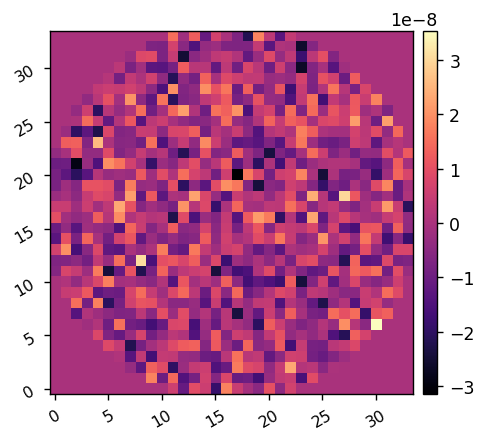

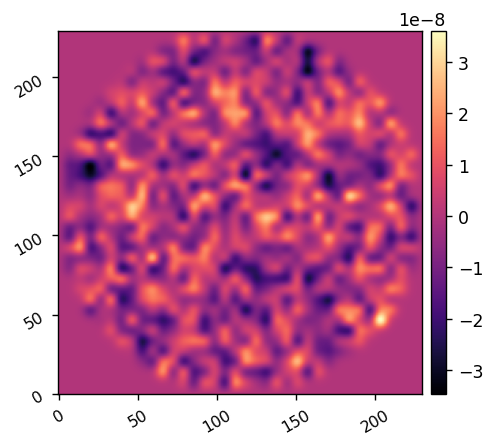

In [65]:
model.set_dm(np.random.randn(model.Nacts)*1e-8)
imshow1(model.get_dm())
imshow1(ensure_np_array(model.get_dm_surface()))
model.reset_dm()

In [116]:
model.focal_grid_pol[0].shape

(2000, 2000)

Jax platform: gpu
Jax device: NVIDIA A100 80GB PCIe


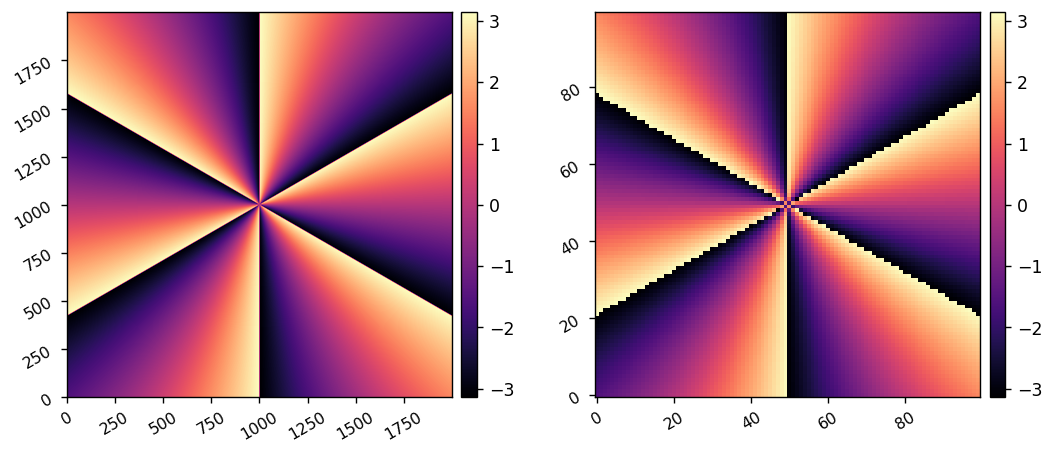

In [81]:
reload(jscoob)
VC = jscoob.make_vortex_phase_mask(model.focal_grid_pol, charge=6, 
#                                    singularity=20*u.um, 
                                   focal_length=500*u.mm, pupil_diam=9.7*u.mm, wavelength=632.8*u.nm)
imshow2(np.angle(jscoob.ensure_np_array(VC)), np.angle(ensure_np_array(jscoob.pad_or_crop(VC, 100))))

Jax platform: gpu
Jax device: NVIDIA A100 80GB PCIe


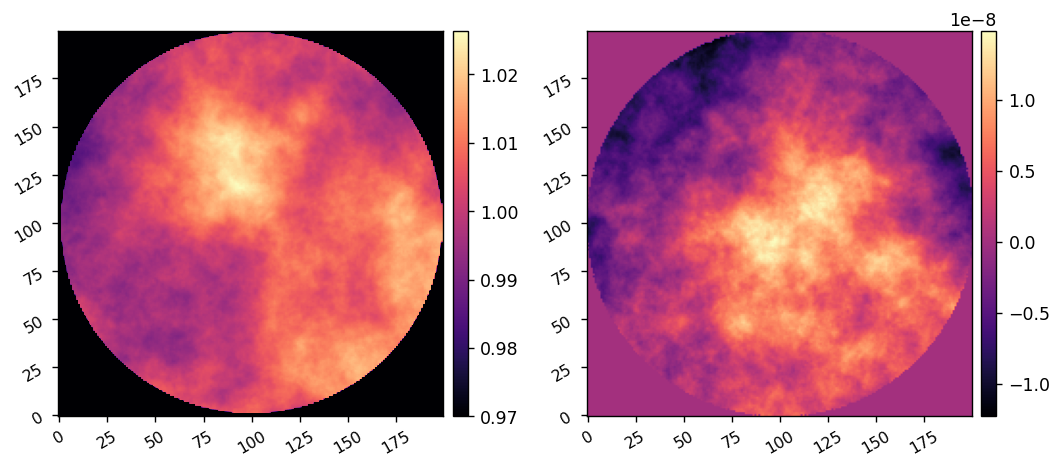

In [82]:
reload(jscoob)
WFE = jscoob.generate_wfe(diam=model.pupil_diam, distance=50*u.mm, 
                          amp_rms=0.02*u.nm, amp_index=3.2,
                          opd_rms=10*u.nm, opd_index=3.2,
                          npix=model.npix, oversample=model.oversample,)
imshow2(ensure_np_array(jnp.abs(WFE)), ensure_np_array(jnp.angle(WFE))/(2*np.pi)*model.wavelength.to_value(u.m), 
        npix=model.npix,
        vmin1=0.97)

In [34]:
amp = ensure_np_array(jnp.abs(WFE))
np.sqrt(np.mean((amp[model.PUPIL]-1)**2 ))

0.05840961001662625

In [8]:
jnp.abs(WFE).max()

Array(1.0001981, dtype=float64)

In [83]:
model.WFE = None
model.WFE = WFE

In [118]:
model.reset_dm()

2023-09-20 10:33:45.878864: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


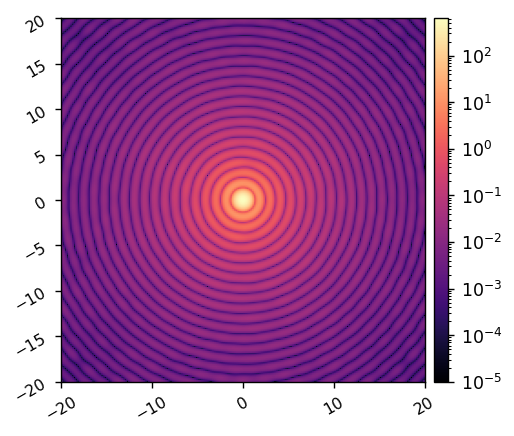

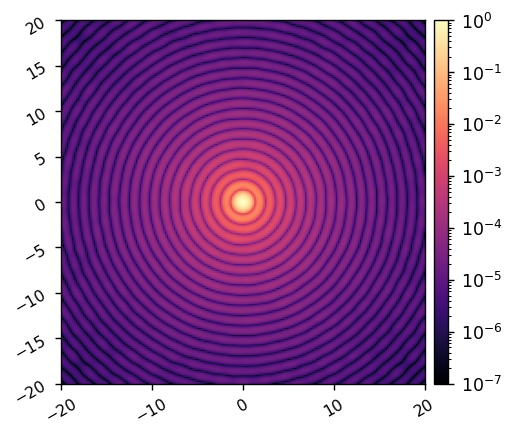

In [84]:

model.FPM = None
ref_unocc_psf = model.snap(plot=True, vmin=1e-5)
model.Imax_ref = ref_unocc_psf.max()
ni_psf = model.snap(plot=True, vmin=1e-7)

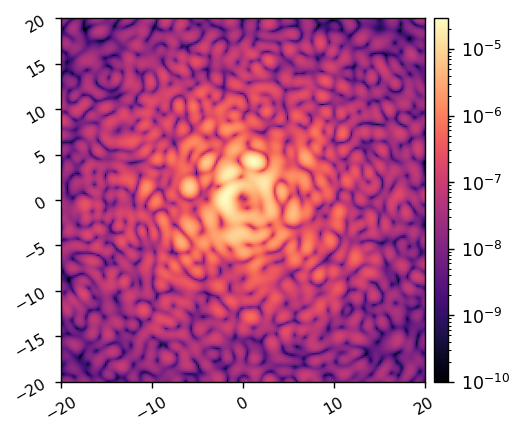

In [85]:
model.FPM = VC
image = model.snap(plot=True, vmin=1e-10)

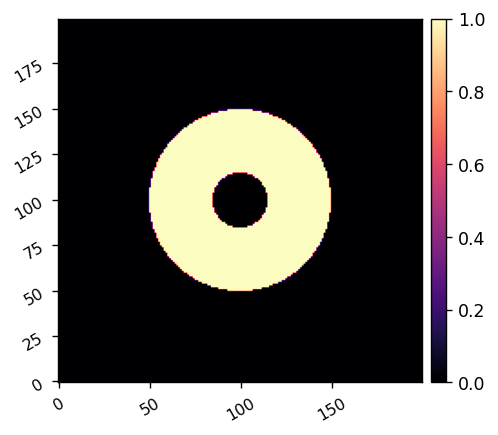

In [75]:
control_mask = (model.im_grid_pol[0] > 3)*(model.im_grid_pol[0] < 10)
imshow1(ensure_np_array(control_mask))

In [55]:
import time
def build_response(sysi, amp, 
                   control_mask,
                   plot=False,
                  ):
    start = time.time()
    dm_mask = sysi.dm_mask.flatten()
    
    ref_wf = ensure_np_array(sysi.propagate())
    
    Nacts = int(dm_mask.sum())
    Nmask = int(control_mask.sum())
    
    num_modes = sysi.Nact**2
    modes = np.eye(num_modes) # each column in this matrix represents a vectorized DM shape where one actuator has been poked
    
    responses = np.zeros((2*Nmask, Nacts))
    count = 0
    print('Calculating Jacobian: ')
    for i in range(num_modes):
        if dm_mask[i]:
            mode = modes[i].reshape(sysi.Nact,sysi.Nact)

            sysi.add_dm(amp*mode)
            wavefront = ensure_np_array(sysi.propagate())
            response = (wavefront - ref_wf) / amp
            sysi.add_dm(-amp*mode)
            
#             responses = responses.at[::2,count].set(response.at[control_mask.ravel()].real)
#             responses = responses.at[1::2,count].set(response.at[control_mask.ravel()].imag)
            responses[::2,count] = response[control_mask].real
            responses[1::2,count] = response[control_mask].imag
            
            print('\tCalculated response for mode {:d}/{:d}. Elapsed time={:.3f} sec.'.format(count+1, Nacts, time.time()-start), end='')
            print("\r", end="")
            count += 1
        else:
            pass
    print()
    print('Jacobian built in {:.3f} sec'.format(time.time()-start))
    
    return responses

In [89]:
import time
def build_response(sysi, amp, 
                   control_mask,
                   plot=False,
                  ):
    start = time.time()
    dm_mask = sysi.dm_mask.flatten()
    
#     ref_wf = ensure_np_array(sysi.propagate())
    
    Nacts = int(dm_mask.sum())
    Nmask = int(control_mask.sum())
    
    num_modes = sysi.Nact**2
    modes = np.eye(num_modes) # each column in this matrix represents a vectorized DM shape where one actuator has been poked
    
    responses = np.zeros((2*Nmask, Nacts))
    count = 0
    print('Calculating Jacobian: ')
    for i in range(num_modes):
        if dm_mask[i]:
            mode = modes[i].reshape(sysi.Nact,sysi.Nact)

            sysi.add_dm(amp*mode)
            wavefront_pos = ensure_np_array(sysi.propagate())
            sysi.add_dm(-amp*mode)
            
            sysi.add_dm(-amp*mode)
            wavefront_neg = ensure_np_array(sysi.propagate())
            sysi.add_dm(amp*mode)
            
            response = (wavefront_pos - wavefront_neg) / 2/amp
            
#             responses = responses.at[::2,count].set(response.at[control_mask.ravel()].real)
#             responses = responses.at[1::2,count].set(response.at[control_mask.ravel()].imag)
            responses[::2,count] = response[control_mask].real
            responses[1::2,count] = response[control_mask].imag
            
            print('\tCalculated response for mode {:d}/{:d}. Elapsed time={:.3f} sec.'.format(count+1, Nacts, time.time()-start), end='')
            print("\r", end="")
            count += 1
        else:
            pass
    print()
    print('Jacobian built in {:.3f} sec'.format(time.time()-start))
    
    return responses

In [90]:
response_matrix = build_response(model, 5e-9, control_mask)

Calculating Jacobian: 
	Calculated response for mode 952/952. Elapsed time=51.790 sec.
Jacobian built in 51.790 sec


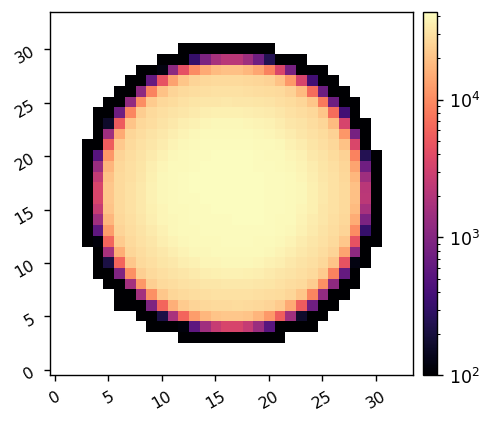

In [91]:
dm_response = np.sqrt(np.mean(np.abs(response_matrix)**2, axis=0))
dm_response = model.DM.map_actuators_to_command(jnp.asarray(dm_response))
imshow1(ensure_np_array(dm_response), lognorm=True, vmin=1e2)

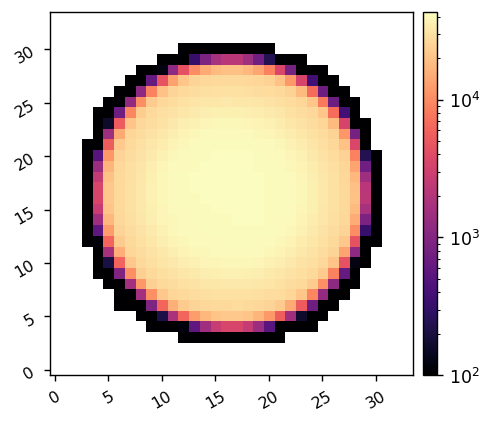

In [87]:
dm_response = np.sqrt(np.mean(np.abs(response_matrix)**2, axis=0))
dm_response = model.DM.map_actuators_to_command(jnp.asarray(dm_response))
imshow1(ensure_np_array(dm_response), lognorm=True, vmin=1e2)

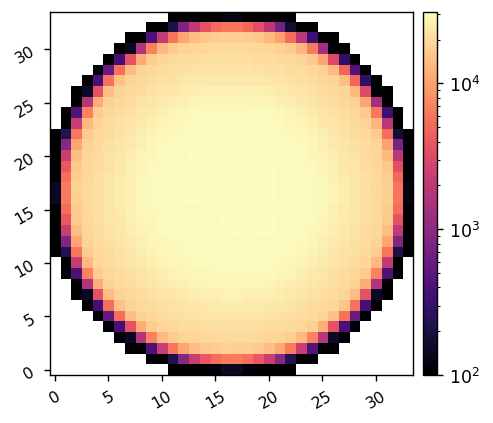

In [79]:
dm_response = np.sqrt(np.mean(np.abs(response_matrix)**2, axis=0))
dm_response = model.DM.map_actuators_to_command(jnp.asarray(dm_response))
imshow1(ensure_np_array(dm_response), lognorm=True, vmin=1e2)